In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
import ast

/home/always1020/anaconda3/envs/si618/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_content = pd.read_csv("S10-M_content_df.csv")

In [3]:
def str_to_vec(text):
    text = text.strip().replace("\n"," ")
    return np.fromstring(text.replace("[","").replace("]",""), sep=' ')

In [4]:
df_content["SubPosEmbedding"] = df_content["SubPosEmbedding"].apply(str_to_vec)
df_content["PositionEmbedding"] = df_content["PositionEmbedding"].apply(str_to_vec)

In [6]:
def get_fragment_trajectory(start_turn, end_turn):
    frag = df_content[(df_content["Position ID"] >= start_turn) &
                        (df_content["Position ID"] <= end_turn)]

    if len(frag) == 0:
        return None
    
    vecs1 = np.vstack(frag["SubPosEmbedding"].values)
    vecs2 = np.vstack(frag["PositionEmbedding"].values)
    dist1 = cosine_distances(vecs1)
    dist2 = cosine_distances(vecs2)
    
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    coords1 = mds.fit_transform(dist1)
    coords2 = mds.fit_transform(dist2)
    
    frag = frag.copy()
    frag["Subx"] = coords1[:,0]
    frag["Suby"] = coords1[:,1]
    frag["Fullx"] = coords2[:,0]
    frag["Fully"] = coords2[:,1]
    
    return frag

In [7]:
def draw_ellipse(x, y, ax, color, alpha=0.18):
    x = np.array(x); y = np.array(y)
    if len(x) < 2:
        return
    cov = np.cov(x, y)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2*np.sqrt(vals)
    ell = Ellipse(xy=(np.mean(x), np.mean(y)),
                    width=width, height=height,
                    angle=theta, edgecolor=color,
                    facecolor=color, alpha=alpha)
    ax.add_patch(ell)

In [21]:
def plot_fragment_trajectory(start_turn, end_turn):
    frag = get_fragment_trajectory(start_turn, end_turn)
    if frag is None:
        print("No meaningful turns in this range.")
        return
    
    colors = {"P1": "#4A90E2", "P2": "#7ED321", "P3": "#9013FE"}

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    # -----------------------------
    # Plot 1: Sub-position embedding trajectory
    # -----------------------------
    for spk in frag["Speaker"].unique():
        df_spk = frag[frag["Speaker"] == spk]
        x, y = df_spk["Subx"], df_spk["Suby"]
        
        ax1.scatter(x, y, s=80, c=colors[spk], alpha=0.7, label=spk)

        if len(x) >= 2:
            ax1.scatter(x.iloc[0], y.iloc[0], c=colors[spk], 
                        s=150, marker="o", edgecolor="black")
            ax1.scatter(x.iloc[-1], y.iloc[-1], c=colors[spk], 
                        s=200, marker="*", edgecolor="black")
            ax1.arrow(x.iloc[0], y.iloc[0],
                      x.iloc[-1] - x.iloc[0],
                      y.iloc[-1] - y.iloc[0],
                      color=colors[spk], head_width=0.02, alpha=0.8)
        
        draw_ellipse(x, y, ax1, colors[spk])

    ax1.set_title(f"Sub-position Trajectory ({start_turn}–{end_turn})", fontsize=14)
    ax1.set_xlabel("Dim 1")
    ax1.set_ylabel("Dim 2")
    ax1.legend()
    ax1.grid(alpha=0.3)


    # -----------------------------
    # Plot 2: Full-position embedding trajectory
    # -----------------------------
    for spk in frag["Speaker"].unique():
        df_spk = frag[frag["Speaker"] == spk]
        x, y = df_spk["Fullx"], df_spk["Fully"]
        
        ax2.scatter(x, y, s=80, c=colors[spk], alpha=0.7, label=spk)

        if len(x) >= 2:
            ax2.scatter(x.iloc[0], y.iloc[0], c=colors[spk], 
                        s=150, marker="o", edgecolor="black")
            ax2.scatter(x.iloc[-1], y.iloc[-1], c=colors[spk], 
                        s=200, marker="*", edgecolor="black")
            ax2.arrow(x.iloc[0], y.iloc[0],
                      x.iloc[-1] - x.iloc[0],
                      y.iloc[-1] - y.iloc[0],
                      color=colors[spk], head_width=0.02, alpha=0.8)
        
        draw_ellipse(x, y, ax2, colors[spk])

    ax2.set_title(f"Full-position Trajectory ({start_turn}–{end_turn})", fontsize=14)
    ax2.set_xlabel("Dim 1")
    ax2.set_ylabel("Dim 2")
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


/home/always1020/anaconda3/envs/si618/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(
/home/always1020/anaconda3/envs/si618/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


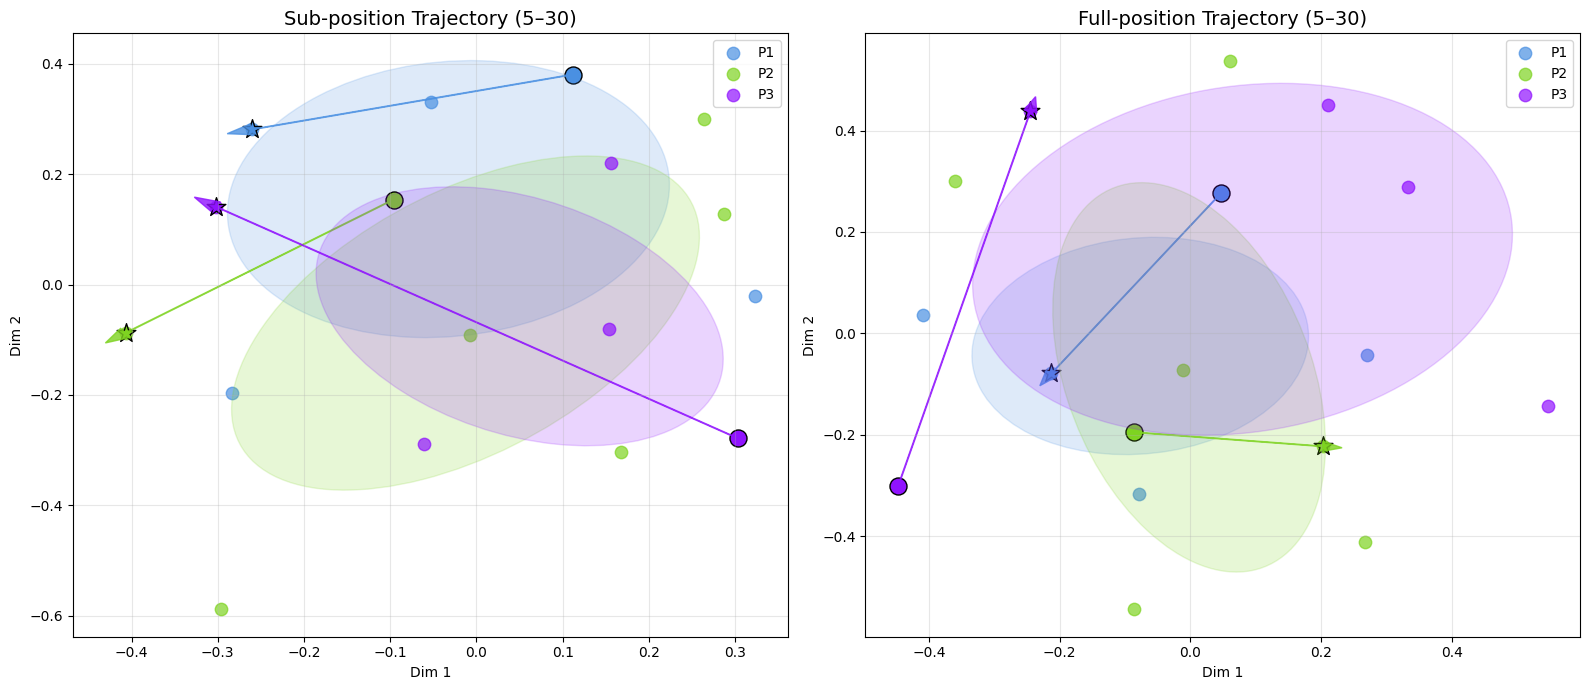

In [22]:
plot_fragment_trajectory(5, 30)